In [1]:
import os
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

In [2]:
face_path = './yalefaces/'
X = []
y_hum = []
y_exp = [] 
#如subject02.centerlight，其y_hum为02，y_exp为centerlight
        
for file in os.listdir(face_path):
    infos = file.split('.')
    hum = infos[0].split('t')[-1]
    ## label starts from 0
    try:
        hum = int(hum) - 1
    except:
        print(hum); break
    exp = infos[1]
    y_hum.append(hum)
    y_exp.append(exp)
    #print(exp)
    ## image
    im_fn = os.path.join(face_path, file)
    gif = imageio.mimread(im_fn)
    gif = gif[0]
    gif = np.array(gif)
    X.append(gif)

In [3]:
def compress_img_CV(img, compress_rate=0.3, show=False):
    heigh, width = img.shape[:2]
    # 双三次插值
    img_resized = cv2.resize(
        img, 
        (int(width*compress_rate), int(heigh*compress_rate)), 
        interpolation=cv2.INTER_AREA
    )

    return img_resized

(72, 96)


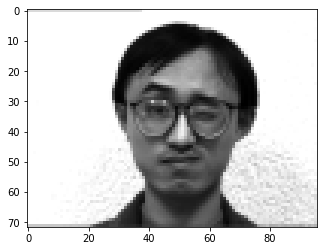

In [4]:
X_resized = [compress_img_CV(x) for x in X]
print(X_resized[0].shape)
plt.imshow(X_resized[0], cmap='gray'); plt.show()

### 压缩后的图像大小为 72*96

## 划分训练集

- 15个人（15个类型），每个人11张不同表情
- 每个类型进入训练集：5
- 进入训练集的表情类型：random

In [5]:
def split_train_set(df, n_keep):
    tmp = []
    crt = None
    cnt = 0
    for hum in df.hum:
        if crt == hum:
            cnt += 1
        else:
            crt = hum
            cnt = 1
        tmp.append(cnt <= n_keep)  # 只保留前 n_keep 项作为训练集
    df['is_train'] = tmp

    x_train = np.array([_ for _ in df[df.is_train].img])
    y_train = np.array([_ for _ in df[df.is_train].hum])
    x_test = np.array([_ for _ in df[-df.is_train].img])
    y_test = np.array([_ for _ in df[-df.is_train].hum])
    
    return x_train, y_train, x_test, y_test

In [6]:
df = pd.DataFrame(zip(X_resized,y_hum), columns=['img', 'hum']).sort_values('hum')
x_train, y_train, x_test, y_test = split_train_set(df, 5)

In [9]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# X_sample = np.array(X_resized)
# n_class = max(y_hum) + 1

# # ## flatten
# # X = X.reshape((X.shape[0], -1))

# #分训练集和测试集，构建标签，只作为样例
# x_train, x_test, y_train, y_test = train_test_split(X_sample, y_hum, train_size = 0.2, random_state = 0)
# y_one_hot = label_binarize(y_test, np.arange(n_class))  

In [7]:
d, h, w = x_train.shape
print(f"d={d}\nh={h}\nw={w}")

d=75
h=72
w=96


#### 训练集 作为 `sample`

In [10]:
sample = x_train.copy()

## PCA

In [8]:
def PCA(X, n_dim=None):
    S = X.reshape(X.shape[0], -1)
    S = S - S.mean(0) 
    G = np.cov(S, rowvar=0) 
    D, V = np.linalg.eig(G) 
    return V[:,:n_dim].real if n_dim else V.real

In [11]:
S1 = sample.reshape(d, -1)
G = np.cov(S1, rowvar=0)
D1, V1 = np.linalg.eig(G)

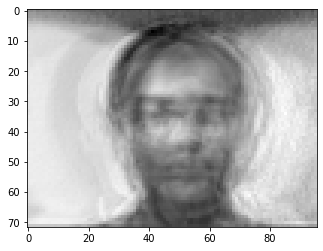

In [12]:
n_dim = 10
U = V1[:,:n_dim].real

img1 = (S1 @ U @ U.T)[-1].reshape(h,w)
plt.imshow(img1, cmap='gray'); plt.show()

## 2DPCA

In [13]:
S2 = sample - sample.mean(0)

G = np.array([A.T @ A for A in S2]).mean(0)
D2, V2 = np.linalg.eig(G)

sorted_index = np.argsort(D2)[::-1]
D2, V2 = D2[sorted_index], V2[sorted_index]

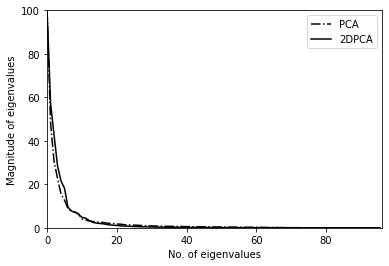

In [14]:
plt.figure(figsize=(6,4))
plt.xlabel('No. of eigenvalues'); plt.ylabel('Magnitude of eigenvalues')
plt.xlim(0,w); plt.ylim(0,100);
# plt.title('Magnitude of Eigenvalues')
plt.plot((D1[:100]/D1[0]*100).real, 'k-.', label='PCA')
plt.plot((D2[:100]/D2[0]*100).real, 'k-', label='2DPCA');
plt.legend()
plt.show()

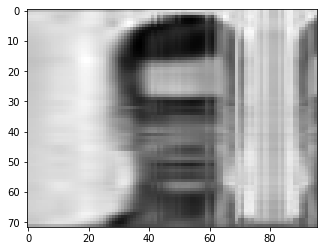

In [15]:
n_dim = 10
U = V2[:,:n_dim].real

img2 = (sample @ U @ U.T)[-1].reshape(h,w)
plt.imshow(img2, cmap='gray'); plt.show()

In [15]:
def PCA2D(X, n_dim=None):
    # Centralize
    S  = X - X.mean(0)
    # Image covariance (scatter) matrix
    G = np.array([A.T @ A for A in S]).mean(0) 
    # Optimal projection axes: orthonormal eigenvectors of G
    D,V = np.linalg.eig(G)
    # Reorder principal eigenvectors
    sorted_index = np.argsort(D)[::-1]
    D,V = D[sorted_index], V[sorted_index]
    return V[:,:n_dim] if n_dim else V

## L1 Norm 2DPCA

In [16]:
def PCA2D_L1(X, n_dim=5):
    # initial value for iteration
    tmp = np.ones(X.shape[-1] ) 
    u0 = tmp / np.linalg.norm(tmp) 
    # 1st iteration
    u = iterate_u(X, u0)
    # following iterations
    ret = []
    ret.append(u) 
    for i in range(n_dim - 1):
        X = update_x(X, u)
        u = iterate_u(X, u0) 
        ret.append(u)
    return np.array(ret).T

def iterate_u(X, u):
    delta = 1 
    while delta != 0:
        Y = X @ u 
        P = (Y>0) * 2 + 1 
        tmp = (P.T * X.T).T.sum(0).sum(0) 
        u = tmp / np.linalg.norm(tmp)
        delta = np.linalg.norm(X @ u, ord=1) - np.linalg.norm(Y, ord=1)
    return u

def update_x(x, u):
    r = x - (x @ u).reshape(x.shape[0], -1, 1) @ u.reshape(1,-1)
    return(r)

In [17]:
S3 = sample
V3 = PCA2D_L1(S3, n_dim=100)

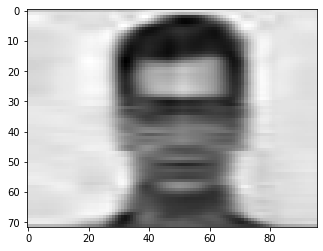

In [18]:
n_dim = 10

U = V3[:,:10]
img3 = (sample @ U @ U.T)[-1].reshape(h,w) 
plt.imshow(img3, cmap='gray'); plt.show()

---
* 样本分布可视化对比

### Reconstructed subimages with 2DPCA & 2DPCA-L1

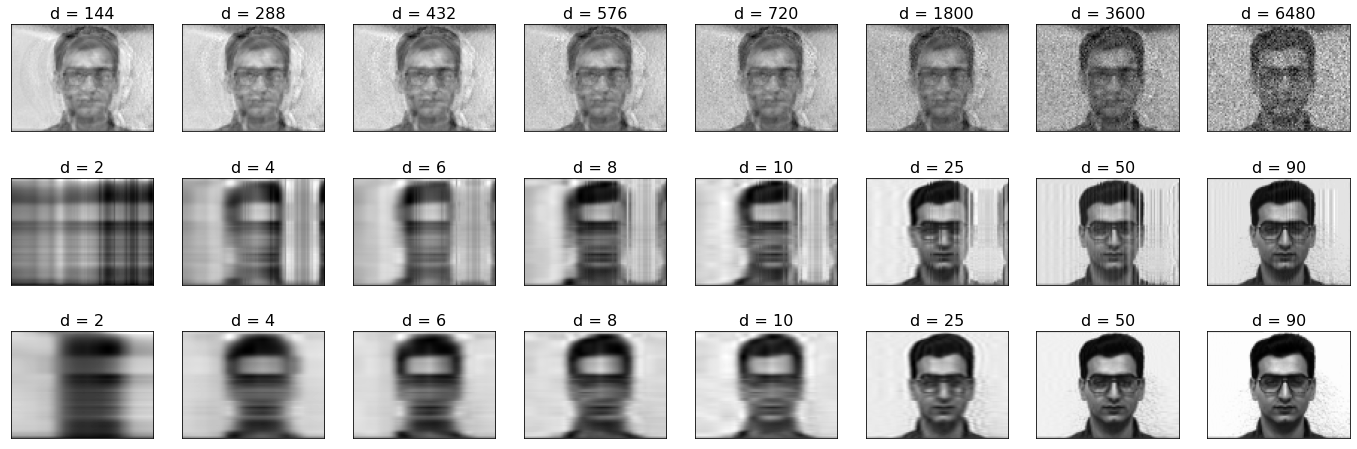

In [21]:
A = x_train[-1]

#画图
n_row = 3
n_col = 8
tap = [2,4,6,8,10,25,50,90]

# Plot the first 12 eignenvalues
plt.figure(figsize=(24,8))
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1)
    u = V1[:, :tap[i]*72].real
    plt.imshow((A.flatten() @ u @ u.T).reshape(A.shape), cmap='gray')
    title_text = 'd = ' + str(tap[i]*72)
    plt.title(title_text, size=16)
    plt.xticks(())
    plt.yticks(())
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1 + n_col)
    u = V2[:, :tap[i]]
    plt.imshow((A @ u).reshape(A.shape[0], -1) @ u.T.reshape(-1,A.shape[1]), cmap='gray')
    title_text = 'd = ' + str(tap[i])
    plt.title(title_text, size=16)
    plt.xticks(())
    plt.yticks(())
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1 + 2*n_col)
    u = V3[:, :tap[i]]
    plt.imshow((A @ u).reshape(A.shape[0], -1) @ u.T.reshape(-1,A.shape[1]), cmap='gray')
    title_text = 'd = ' + str(tap[i])
    plt.title(title_text, size=16)
    plt.xticks(())
    plt.yticks(())
plt.show()

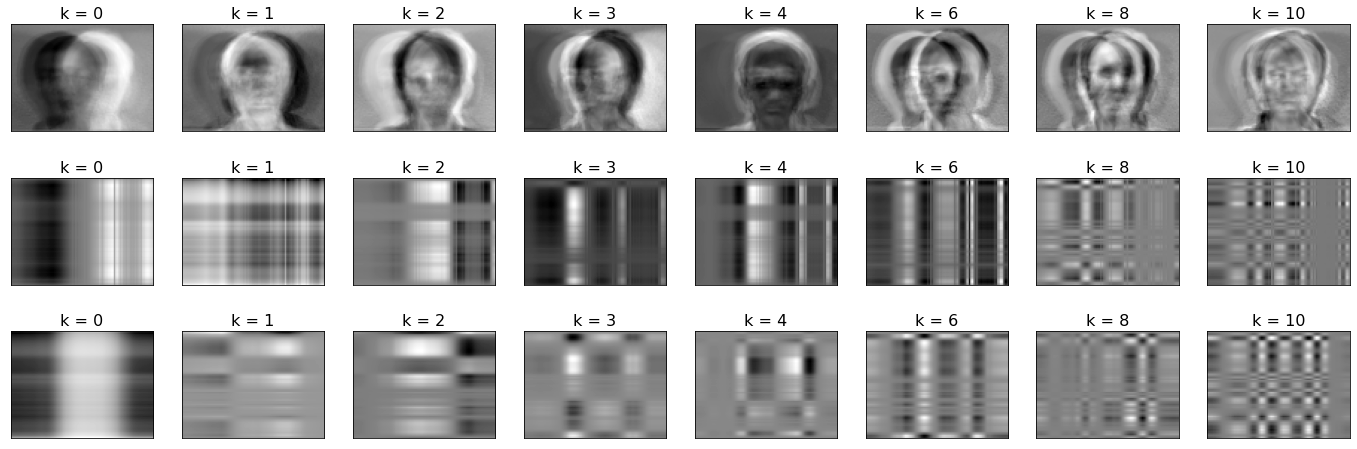

In [22]:
A = x_train[-1]

#画图
n_row = 3
n_col = 8
tap = [0,1,2,3,4,6,8,10]

# Plot the first 12 eignenvalues
plt.figure(figsize=(24,8))
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1)
    u = V1[:, tap[i]].real
    plt.imshow((A.flatten() @ u * u).reshape(A.shape), cmap='gray_r')
    title_text = 'k = ' + str(tap[i])
    plt.title(title_text, size=16)
    plt.xticks(())
    plt.yticks(())
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1 + n_col)
    u = V2[:, tap[i]]
    plt.imshow((A @ u).reshape(A.shape[0], -1) @ u.T.reshape(-1,A.shape[1]), cmap='gray_r')
    title_text = 'k = ' + str(tap[i])
    plt.title(title_text, size=16)
    plt.xticks(())
    plt.yticks(())
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1 + 2 * n_col)
    u = V3[:, tap[i]]
    plt.imshow((A @ u).reshape(A.shape[0], -1) @ u.T.reshape(-1,A.shape[1]), cmap='gray_r')
    title_text = 'k = ' + str(tap[i])
    plt.title(title_text, size=16)
    plt.xticks(())
    plt.yticks(())
plt.show()

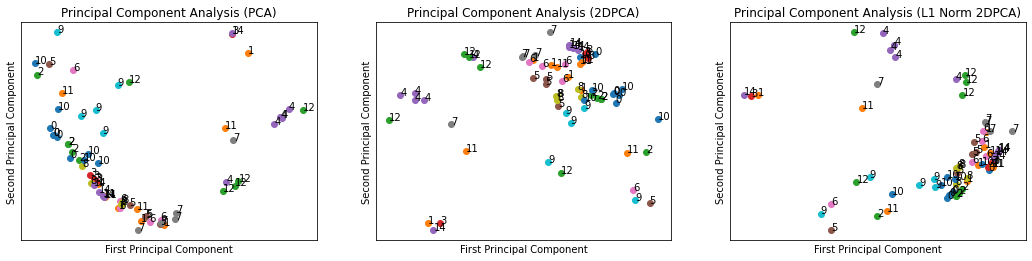

In [19]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
u0 = V1[:,0].real
u1 = V1[:,1].real

cluster_x = [[] for _ in range(15)]
cluster_y = [[] for _ in range(15)] 

x = x_train.reshape(x_train.shape[0],-1) @ u0
y = x_train.reshape(x_train.shape[0],-1) @ u1

for i in range(70):
    idx = y_train[i] - 1
    cluster_x[idx].append(x[i]) 
    cluster_y[idx].append(y[i])

# plt.figure(figsize=(6,4))
plt.title("Principal Component Analysis (PCA)") 
plt.ylabel("Second Principal Component") 
plt.xlabel("First Principal Component")
for idx in range(15):
    plt.scatter(cluster_x[idx], cluster_y[idx], marker='o')
for ci in range(15):
    _x = cluster_x[ci]
    _y = cluster_y[ci]
    for i in range(0,len(_x)):
        plt.annotate(str(ci),(_x[i],_y[i]))
        
plt.xticks([])
plt.yticks([])


## 
plt.subplot(1,3,2)
u0 = V2[:,0]
u1 = V2[:,1]

cluster_x = [[] for _ in range(15)]
cluster_y = [[] for _ in range(15)] 

# x = np.linalg.norm(x_train @ u0, ord=2, axis=1)
# y = np.linalg.norm(x_train @ u1, ord=2, axis=1)
x = (x_train @ u0).sum(1)
y = (x_train @ u1).sum(1)

for i in range(70):
    idx = y_train[i] - 1
    cluster_x[idx].append(x[i]) 
    cluster_y[idx].append(y[i])

# plt.figure(figsize=(6,4))
plt.title("Principal Component Analysis (2DPCA)") 
plt.ylabel("Second Principal Component") 
plt.xlabel("First Principal Component")
for idx in range(15):
    plt.scatter(cluster_x[idx], cluster_y[idx], marker='o')
for ci in range(15):
    _x = cluster_x[ci]
    _y = cluster_y[ci]
    for i in range(0,len(_x)):
        plt.annotate(str(ci),(_x[i],_y[i]))
plt.xticks([])
plt.yticks([])

## 
plt.subplot(1,3,3)
u0 = V3[:,0]
u1 = V3[:,1]

cluster_x = [[] for _ in range(15)]
cluster_y = [[] for _ in range(15)] 

# x = np.linalg.norm(x_train @ u0, axis=1)
# y = np.linalg.norm(x_train @ u1, axis=1)
x = (x_train @ u0).sum(1)
y = (x_train @ u1).sum(1)

for i in range(70):
    idx = y_train[i] - 1
    cluster_x[idx].append(x[i]) 
    cluster_y[idx].append(y[i])

# plt.figure(figsize=(6,4))
plt.title("Principal Component Analysis (L1 Norm 2DPCA)") 
plt.ylabel("Second Principal Component") 
plt.xlabel("First Principal Component")

for idx in range(15):
    plt.scatter(cluster_x[idx], cluster_y[idx], marker='o')
for ci in range(15):
    _x = cluster_x[ci]
    _y = cluster_y[ci]
    for i in range(0,len(_x)):
        plt.annotate(str(ci),(_x[i],_y[i]))
plt.xticks([]);plt.yticks([])
plt.show()

* 聚类算法效果对比（可以不限于k-means，请计算召回率/准确率/F值作为定量指标）


In [20]:
from sklearn.cluster import KMeans # KMeans clustering   
from sklearn.metrics import adjusted_mutual_info_score  # ARI

In [21]:
def f_score(cluster, labels):
    TP, TN, FP, FN = 0, 0, 0, 0
    n = len(labels)
    # a lookup table
    for i in range(n):
        for j in range(i + 1, n):
            same_label = (labels[i] == labels[j])
            same_cluster = (cluster[i] == cluster[j])
            if same_cluster:
                if same_label:
                    TP += 1
                else:
                    FP += 1
            elif same_label:
                FN += 1
            else:
                TN += 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fscore = 2 * precision * recall / (precision + recall)
    return fscore, precision, recall, TP + FP + FN + TN

|    |ARI|F-Score|Precision|Recall|
|------|------|------|------|------|
|PCA|0.2784|0.2448|0.2216|0.2733|
|2DPCA|0.3461|0.2833|0.2463|0.3333|
|L1-2DPCA|0.3281|0.2700|0.2160|0.3600|


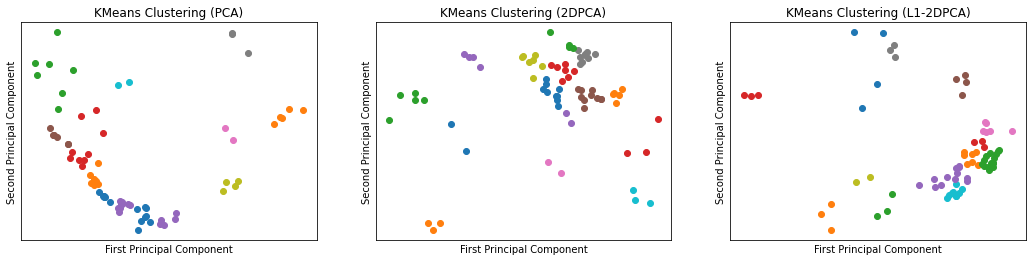

In [22]:
plt.figure(figsize=(18,4))  
print("|    |ARI|F-Score|Precision|Recall|")
print("|" + "------|" * 5)

plt.subplot(1,3,1)
X_2d = (x_train.reshape(d,-1) @ V1[:,:2].real)

cluster_num = 15
# Set a KMeans clustering with 15 components 

kmeans = KMeans(n_clusters=cluster_num)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_2d)


cluster_X = [[] for _ in range(cluster_num)]
cluster_Y = [[] for _ in range(cluster_num)]
for i in range(len(X_clustered)):
    cluster_X[X_clustered[i]].append(X_2d[i][0]) 
    cluster_Y[X_clustered[i]].append(X_2d[i][1]) 
    
# plt.figure(figsize=(6,4)) 
plt.title("KMeans Clustering (PCA)") 
plt.ylabel("Second Principal Component") 
plt.xlabel("First Principal Component")

for ci in range(len(cluster_X)):
    _x = cluster_X[ci]
    _y = cluster_Y[ci]
    plt.scatter(_x, _y, marker='o')

plt.xticks([]);plt.yticks([])
# print('\n (PCA)')
# print("ARI:\t%.6f"  % (adjusted_mutual_info_score(y_train, X_clustered)))
# print("F-Score:\t%.4f\nPrecision:\t%.4f\nRecall:\t%.4f\n" % f_score(kmeans.labels_,y_train)[:-1])
r1 = adjusted_mutual_info_score(y_train, X_clustered) 
r2, r3, r4 = f_score(kmeans.labels_,y_train)[:-1]
print("|PCA|%.4f|%.4f|%.4f|%.4f|" % (r1,r2,r3,r4))

plt.subplot(1,3,2)
X_2d = (x_train @ V2[:,:2]).sum(1)

cluster_num = 15
# Set a KMeans clustering with 15 components 

kmeans = KMeans(n_clusters=cluster_num)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_2d)

cluster_X = [[] for _ in range(cluster_num)]
cluster_Y = [[] for _ in range(cluster_num)]
for i in range(len(X_clustered)):
    cluster_X[X_clustered[i]].append(X_2d[i][0]) 
    cluster_Y[X_clustered[i]].append(X_2d[i][1]) 
    
# plt.figure(figsize=(6,4)) 
plt.title("KMeans Clustering (2DPCA)") 
plt.ylabel("Second Principal Component") 
plt.xlabel("First Principal Component")

for ci in range(len(cluster_X)):
    _x = cluster_X[ci]
    _y = cluster_Y[ci]
    plt.scatter(_x, _y, marker='o')

# plt.show()
plt.xticks([]);plt.yticks([])

# print("\n (2DPCA)")
# print("ARI:\t%.6f"  % (adjusted_mutual_info_score(y_train, X_clustered)))
# print("F-Score:\t%.4f\nPrecision:\t%.4f\nRecall:\t%.4f\n" % f_score(kmeans.labels_,y_train)[:-1])
r1 = adjusted_mutual_info_score(y_train, X_clustered) 
r2, r3, r4 = f_score(kmeans.labels_,y_train)[:-1]
print("|2DPCA|%.4f|%.4f|%.4f|%.4f|" % (r1,r2,r3,r4))

##
plt.subplot(1,3,3)
X_2d = (x_train @ V3[:,:2]).sum(1)

cluster_num = 15
# Set a KMeans clustering with 15 components 

kmeans = KMeans(n_clusters=cluster_num)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_2d)

cluster_X = [[] for _ in range(cluster_num)]
cluster_Y = [[] for _ in range(cluster_num)]
for i in range(len(X_clustered)):
    cluster_X[X_clustered[i]].append(X_2d[i][0]) 
    cluster_Y[X_clustered[i]].append(X_2d[i][1]) 
    
# plt.figure(figsize=(6,4)) 
plt.title("KMeans Clustering (L1-2DPCA)") 
plt.ylabel("Second Principal Component") 
plt.xlabel("First Principal Component")

for ci in range(len(cluster_X)):
    _x = cluster_X[ci]
    _y = cluster_Y[ci]
    plt.scatter(_x, _y, marker='o')
plt.xticks([]);plt.yticks([])

r1 = adjusted_mutual_info_score(y_train, X_clustered) 
r2, r3, r4 = f_score(kmeans.labels_,y_train)[:-1]
print("|L1-2DPCA|%.4f|%.4f|%.4f|%.4f|" % (r1,r2,r3,r4))
# print("\n (L1-2DPCA)")
# print("ARI:\t%.6f"  % (adjusted_mutual_info_score(y_train, X_clustered)))
# print("ARI:\t%.6f\tF-Score:\t%.4f\nPrecision:\t%.4f\nRecall:\t%.4f\n" % (r1,r2,r3,r4))
plt.show()

* 分类对比（可以使用KNN、朴素贝叶斯等分类器）

## Classification Method

- Define the distance btw. two arbitrary feature matrices, $B_{i} = \left[  Y_{1}^{(i)}, Y_{2}^{(i)}, \dots , Y_{d}^{(i)}  \right]$ and $B_{j} = \left[  Y_{1}^{(j)}, Y_{2}^{(j)}, \dots , Y_{d}^{(j)}  \right]$, as
$$
d(B_{i}, B_{j}) = \sum_{k=1}^{d}{\left|\left|Y_{k}^{(i)} - Y_{k}^{(j)}\right|\right|_{2} },
$$
where $\left|\left|Y_{k}^{(i)} - Y_{k}^{(j)}\right|\right|_{2}$ denotes the Euclidean distance btw. the two principal component vectors $Y_{k}^{(i)}$ and $Y_{k}^{(j)}$

- The training samples are $B_1, B_2, \dots, B_M$ from `x_train`. Each of these samples is assigned a given class $\omega_{k}$ from `y_train`.
- Given a test sample $B$ from `x_test`, if $d(B, B_{l}) = \min_{j}{d(B, B_{j})}$ and $B_{l} \in \omega_{k}$, then the resulting decision is $B \in \omega_{k}$


In [ ]:
df = pd.DataFrame(zip(X_resized,y_hum), columns=['img', 'hum']).sort_values('hum')
# acc_res = {'PCA':{}, '2DPCA':{}, 'L12D':{}}

In [47]:
n_keep = 1
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

V1 = PCA(x_train)
V2 = PCA2D(x_train)
V3 = PCA2D_L1(x_train)

# plt.figure(figsize=(18, 4))
i_range = 20

######A

acc_res_1 = {}
for i in range(i_range+1):
    acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)
    
    acc_res_1[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,1)
######

acc_res_2 = {}
for i in range(i_range+1):
    acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)
    
    acc_res_2[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,2)

#######

acc_res_3 = {}
for i in range(i_range+1):
    acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
    acc_res_3[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")
        
# plt.subplot(1,3,3)

####
acc_res['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
acc_res['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
acc_res['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()

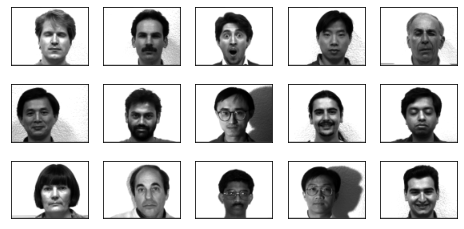

In [27]:
plt.figure(figsize=(8,4))
for i in range(x_train.shape[0]):
    plt.subplot(3,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

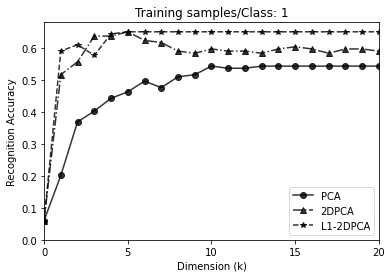

In [83]:
n_total = 1
plt.figure(figsize=(6*n_total, 4))

for n_keep in range(1,n_total+1):
    plt.subplot(1,n_total,n_keep)            

    plt.plot(acc_res['PCA'][n_keep], 'ko-', alpha=.8, label="PCA")
    plt.plot(acc_res['2DPCA'][n_keep], 'k^-.', alpha=.8,  label="2DPCA")
    plt.plot(acc_res['L12D'][n_keep], 'k*--', alpha=.8, label='L1-2DPCA')

    plt.title("Training samples/Class: %d" % n_keep)
    plt.xlim(0,i_range)
    plt.xticks(range(0,21,5))
    plt.ylim(0,)
    plt.xlabel("Dimension (k)")
    plt.ylabel("Recognition Accuracy") 
    plt.legend()

plt.show()

### 分类准确性

依次取前 1..20 个维数的投影向量(projection vectors)提取原图像的特征，计算预测集和训练集特征量的“距离”（定义见上）

In [89]:
def acc_cpt_1d(U_mat, x_train, x_test, y_train, y_test, n_dim=None):
    res = []
    
    if n_dim is None:
        n_dim = U_mat.shape[1]
    else:
        n_dim = n_dim
        
    U = U_mat[:,:n_dim].real.copy()
    
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    for i_test in range(len(x_test)):
        diff = (x_train @ U) - (x_test @ U)[i_test]

        i_train = np.argmin(np.linalg.norm(diff, axis=1))

        res.append(y_test[i_test] == y_train[i_train])

    return np.array(res)


def acc_cpt(U_mat, x_train, x_test, y_train, y_test, n_dim=None):
    res = []
    if n_dim is None:
        n_dim = U_mat.shape[1]
    U = U_mat[:,:n_dim].copy()
    
    for i_test in range(len(x_test)):
        diff = (x_train @ U) - (x_test @ U)[i_test]

        i_train = np.argmin([np.linalg.norm(x, axis=0).sum() for x in diff])

        res.append(y_test[i_test] == y_train[i_train])

    return np.array(res)

---

In [ ]:
n_keep = 2
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

V1 = PCA(x_train)
V2 = PCA2D(x_train)
V3 = PCA2D_L1(x_train)

# plt.figure(figsize=(18, 4))
i_range = 20

######A

acc_res_1 = {}
for i in range(i_range+1):
    acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)
    
    acc_res_1[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,1)
######

acc_res_2 = {}
for i in range(i_range+1):
    acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)
    
    acc_res_2[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,2)

#######

acc_res_3 = {}
for i in range(i_range+1):
    acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
    acc_res_3[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")
        
# plt.subplot(1,3,3)

####
acc_res['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
acc_res['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
acc_res['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()

In [76]:
n_keep = 3
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

V1 = PCA(x_train)
V2 = PCA2D(x_train)
V3 = PCA2D_L1(x_train)

# plt.figure(figsize=(18, 4))
i_range = 20

######A

acc_res_1 = {}
for i in range(i_range+1):
    acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)
    
    acc_res_1[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,1)
######

acc_res_2 = {}
for i in range(i_range+1):
    acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)
    
    acc_res_2[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,2)

#######

acc_res_3 = {}
for i in range(i_range+1):
    acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
    acc_res_3[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")
        
# plt.subplot(1,3,3)

####
acc_res['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
acc_res['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
acc_res['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [81]:
n_keep = 4
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

V1 = PCA(x_train)
V2 = PCA2D(x_train)
V3 = PCA2D_L1(x_train)

# plt.figure(figsize=(18, 4))
i_range = 20

######A

acc_res_1 = {}
for i in range(i_range+1):
    acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)
    
    acc_res_1[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,1)
######

acc_res_2 = {}
for i in range(i_range+1):
    acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)
    
    acc_res_2[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,2)

#######

acc_res_3 = {}
for i in range(i_range+1):
    acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
    acc_res_3[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")
        
# plt.subplot(1,3,3)

####
acc_res['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
acc_res['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
acc_res['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [84]:
n_keep = 5
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

V1 = PCA(x_train)
V2 = PCA2D(x_train)
V3 = PCA2D_L1(x_train)

# plt.figure(figsize=(18, 4))
i_range = 20

######A

acc_res_1 = {}
for i in range(i_range+1):
    acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)
    
    acc_res_1[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,1)
######

acc_res_2 = {}
for i in range(i_range+1):
    acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)
    
    acc_res_2[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,2)

#######

acc_res_3 = {}
for i in range(i_range+1):
    acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
    acc_res_3[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")
        
# plt.subplot(1,3,3)

####
acc_res['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
acc_res['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
acc_res['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [ ]:
n_keep = 6
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

V1 = PCA(x_train)
V2 = PCA2D(x_train)
V3 = PCA2D_L1(x_train)

# plt.figure(figsize=(18, 4))

In [169]:

i_range = 25

######A

acc_res_1 = {}
for i in range(i_range+1):
    acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)
    
    acc_res_1[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,1)
######

acc_res_2 = {}
for i in range(i_range+1):
    acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)
    
    acc_res_2[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")

# plt.subplot(1,3,2)

#######

acc_res_3 = {}
for i in range(i_range+1):
    acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
    acc_res_3[i] = acc
    if i % 5 == 0:
        print(f"FINISHED n_dim = {i}")
        
# plt.subplot(1,3,3)

####
acc_res['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
acc_res['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
acc_res['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 25
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 25
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 25


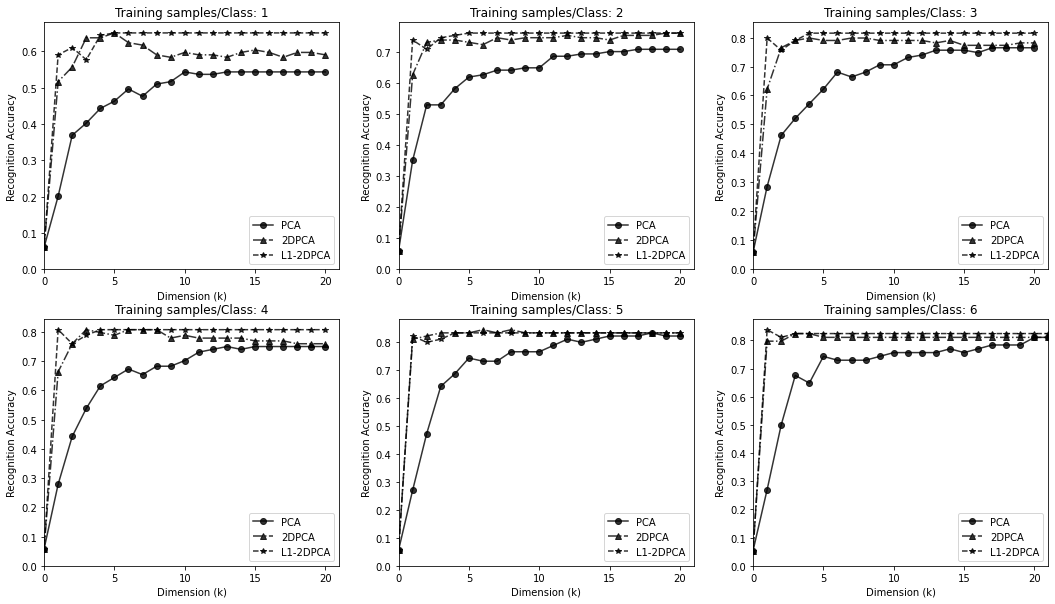

In [175]:
n_total =  6
plt.figure(figsize=(6*3, 5*2))

for n_keep in range(1,n_total+1):
    plt.subplot(2,3,n_keep)            

    plt.plot(acc_res['PCA'][n_keep], 'ko-', alpha=.8, label="PCA")
    plt.plot(acc_res['2DPCA'][n_keep], 'k^-.', alpha=.8,  label="2DPCA")
    plt.plot(acc_res['L12D'][n_keep], 'k*--', alpha=.8, label='L1-2DPCA')

    plt.title("Training samples/Class: %d" % n_keep)
    plt.xlim(0,21)
    plt.xticks(range(0,21,5))
    plt.ylim(0,)
    plt.xlabel("Dimension (k)")
    plt.ylabel("Recognition Accuracy") 
    plt.legend()

plt.show()

In [176]:
df1 = pd.DataFrame(acc_res)
print('|sample per class|1|2|3|4|5|6|')
print('|' + '--|' * 7)
print('|%s|%s|' % ('PCA', '|'.join(["%.2f (%d)" % (y*100,x) for x, y in zip(df1.PCA.apply(np.argmax), df1.PCA.apply(np.max))])))
print('|%s|%s|' % ('2DPCA', '|'.join(["%.2f (96,%d)" % (y*100,x) for x, y in zip(df1['2DPCA'].apply(np.argmax), df1['2DPCA'].apply(np.max))])))
print('|%s|%s|' % ('L1-2DPCA', '|'.join(["%.2f (96,%d)" % (y*100,x) for x, y in zip(df1['L12D'].apply(np.argmax), df1['L12D'].apply(np.max))])))


|sample per class|1|2|3|4|5|6|
|--|--|--|--|--|--|--|
|PCA|70.90 (17)|54.36 (10)|76.47 (17)|75.00 (13)|83.15 (18)|81.08 (20)|
|2DPCA|76.12 (96,19)|65.10 (96,5)|79.83 (96,4)|80.77 (96,3)|84.27 (96,6)|82.43 (96,3)|
|L1-2DPCA|76.12 (96,5)|65.10 (96,5)|81.51 (96,4)|80.77 (96,1)|83.15 (96,4)|83.78 (96,1)|


## 添加遮挡信息

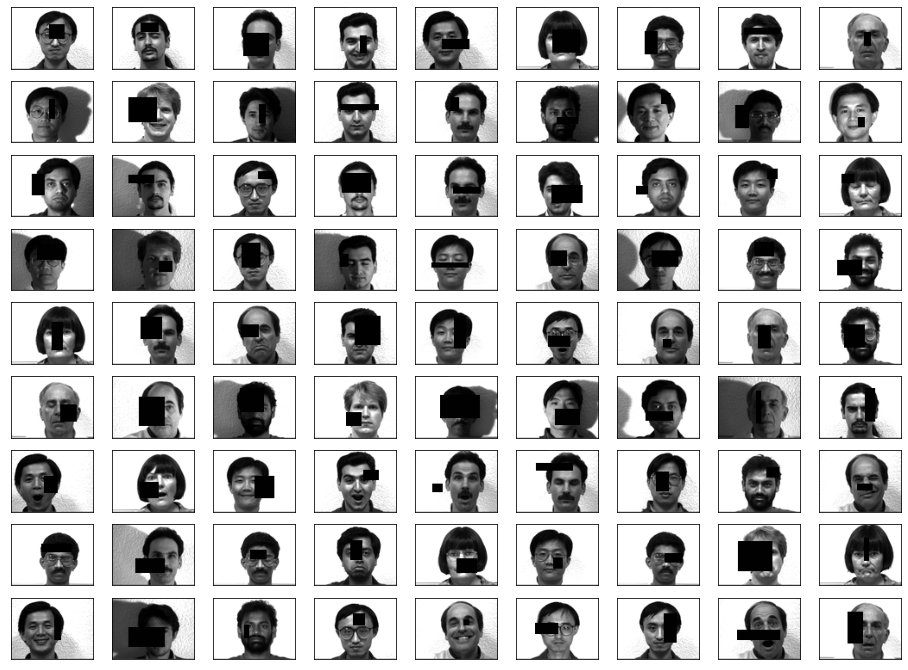

In [94]:
from PIL import Image, ImageDraw
import pylab
import random


face_path = './yalefaces/'
X_obst = []
random.seed(99)
        
for file in os.listdir(face_path):
    im_fn = os.path.join(face_path, file)
    gif = Image.open(im_fn).resize((w,h), Image.ANTIALIAS)
    
    draw = ImageDraw.Draw(gif) 
    x1 = random.randint(int(w*.2), int(w*.6)); x2 = x1 + random.randint(5, int(w*.8)-x1);
    y1 = random.randint(int(h*.2), int(h*.6)); y2 = y1 + random.randint(5, int(h*.8)-y1);
    draw.rectangle((x1,y1,x2,y2), fill = 1) # (0,0,0))
    
    X_obst.append(np.asarray(gif))
    
    
plt.figure(figsize=(16,12))
for i in range(81):
    plt.subplot(9,9,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(X_obst[i], cmap='gray')
plt.show()

In [183]:
df_obst = pd.DataFrame(zip(X_obst,y_hum), columns=['img', 'hum']).sort_values('hum')
# acc_res_obst = {'PCA':{}, '2DPCA':{}, 'L12D':{}}

def process_obst(n_keep):
    x_train, y_train, x_test, y_test = split_train_set(df_obst, n_keep)

    V1 = PCA(x_train)
    V2 = PCA2D(x_train)
    V3 = PCA2D_L1(x_train)

    ######
    i_range = 20

    ######PCA
    acc_res_1 = {}
    for i in range(i_range+1):
        acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)

        acc_res_1[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    ######2DPCA
    acc_res_2 = {}
    for i in range(i_range+1):
        acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)

        acc_res_2[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    #######L12DPCA
    acc_res_3 = {}
    for i in range(i_range+1):
        acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
        acc_res_3[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    ####
    acc_res_obst['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
    acc_res_obst['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
    acc_res_obst['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()
    
def draw_rcgacc_obst(n_total):
    plt.figure(figsize=(18, 15))

    for n_keep in range(1,n_total+1):
        plt.subplot(3,3,n_keep)            

        plt.plot(acc_res_obst['PCA'][n_keep], 'ko-', alpha=.8, label="PCA")
        plt.plot(acc_res_obst['2DPCA'][n_keep], 'k^-.', alpha=.8,  label="2DPCA")
        plt.plot(acc_res_obst['L12D'][n_keep], 'k*--', alpha=.8, label='L1-2DPCA')

        plt.title("(Black Occluder) Training samples/Class: %d" % n_keep)
        plt.xlim(0,i_range)
        plt.xticks(range(0,21,5))
        plt.ylim(0,)
        plt.xlabel("Dimension (k)")
        plt.ylabel("Recognition Accuracy") 
        plt.legend()

    plt.show()

In [91]:
process_obst(1)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [93]:
process_obst(2)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [97]:
process_obst(3)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [105]:
process_obst(4)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [108]:
process_obst(5)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


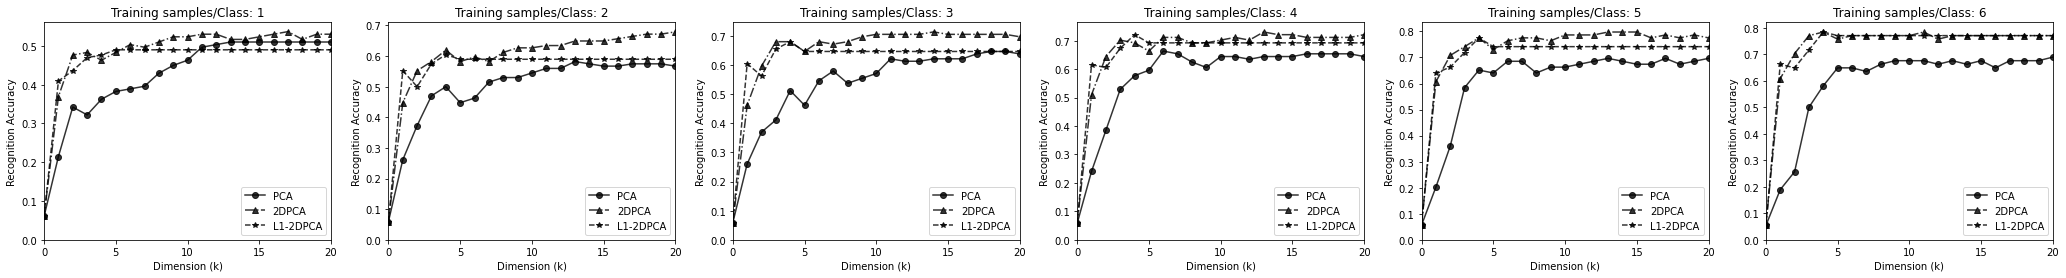

In [112]:
process_obst(6)

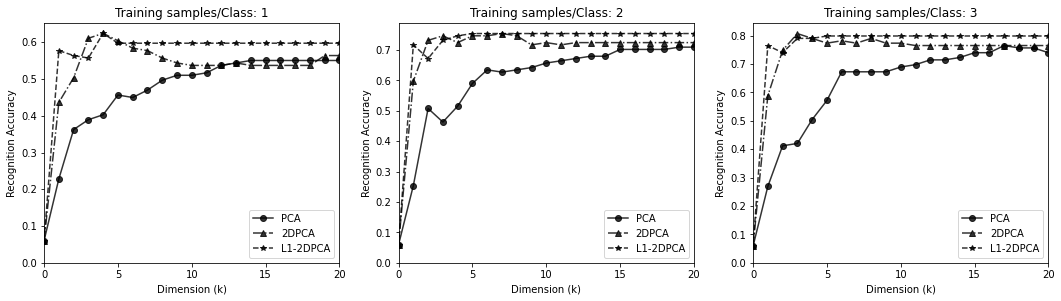

In [135]:
draw_rcgacc_obst(3)

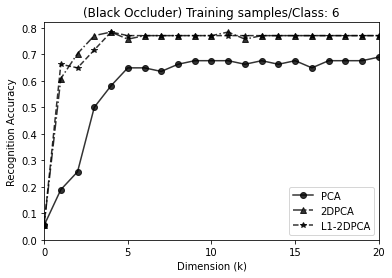

In [181]:
n_total = 6
plt.figure(figsize=(6, 4))

for n_keep in range(6,n_total+1):
    plt.subplot(1,1,1)            

    plt.plot(acc_res_obst['PCA'][n_keep], 'ko-', alpha=.8, label="PCA")
    plt.plot(acc_res_obst['2DPCA'][n_keep], 'k^-.', alpha=.8,  label="2DPCA")
    plt.plot(acc_res_obst['L12D'][n_keep], 'k*--', alpha=.8, label='L1-2DPCA')

    plt.title("(Black Occluder) Training samples/Class: %d" % n_keep)
    plt.xlim(0,i_range)
    plt.xticks(range(0,21,5))
    plt.ylim(0,)
    plt.xlabel("Dimension (k)")
    plt.ylabel("Recognition Accuracy") 
    plt.legend()

plt.show()

### 遮挡信息二

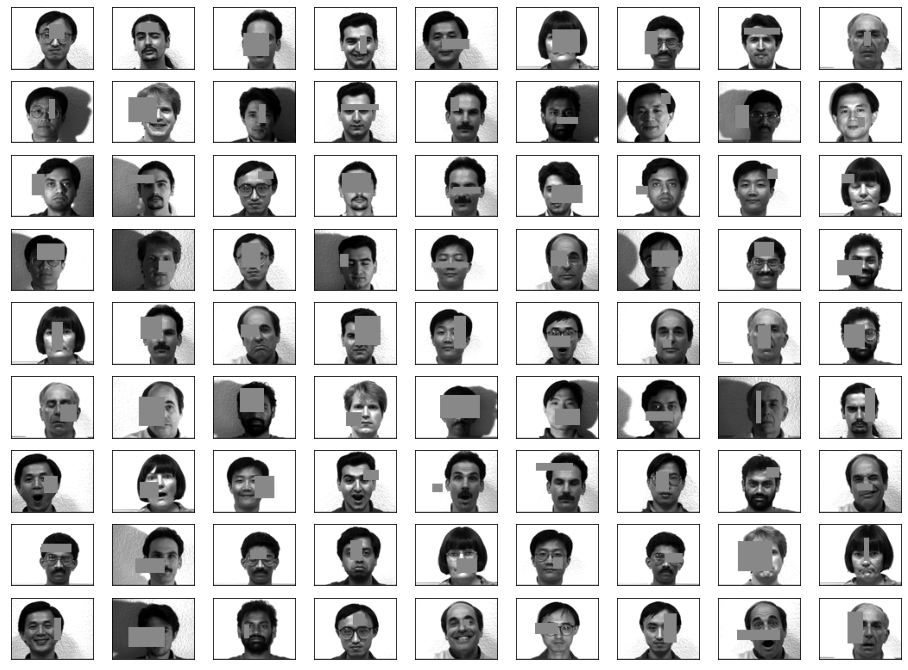

In [124]:
from PIL import Image, ImageDraw
import pylab
import random


face_path = './yalefaces/'
X_obst2 = []
random.seed(99)
        
for file in os.listdir(face_path):
    im_fn = os.path.join(face_path, file)
    gif = Image.open(im_fn).resize((w,h), Image.ANTIALIAS)
    
    draw = ImageDraw.Draw(gif) 
    x1 = random.randint(int(w*.2), int(w*.6)); x2 = x1 + random.randint(5, int(w*.8)-x1);
    y1 = random.randint(int(h*.2), int(h*.6)); y2 = y1 + random.randint(5, int(h*.8)-y1);
    draw.rectangle((x1,y1,x2,y2), fill = "#888888") # (0,0,0))
    
    X_obst2.append(np.asarray(gif))
    
    
plt.figure(figsize=(16,12))
for i in range(81):
    plt.subplot(9,9,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(X_obst2[i], cmap='gray')
plt.show()

In [ ]:
df_obst2 = pd.DataFrame(zip(X_obst2,y_hum), columns=['img', 'hum']).sort_values('hum')
# acc_res_obst2 = {'PCA':{}, '2DPCA':{}, 'L12D':{}}

In [184]:
def process_obst2(n_keep):
    x_train, y_train, x_test, y_test = split_train_set(df_obst2, n_keep)

    V1 = PCA(x_train)
    V2 = PCA2D(x_train)
    V3 = PCA2D_L1(x_train)

    ######
    i_range = 20

    ######PCA
    acc_res_1 = {}
    for i in range(i_range+1):
        acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)

        acc_res_1[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    ######2DPCA
    acc_res_2 = {}
    for i in range(i_range+1):
        acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)

        acc_res_2[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    #######L12DPCA
    acc_res_3 = {}
    for i in range(i_range+1):
        acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
        acc_res_3[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    ####
    acc_res_obst2['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
    acc_res_obst2['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
    acc_res_obst2['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()
    
def draw_rcgacc_obst2(n_total):
    plt.figure(figsize=(18, 15))

    for n_keep in range(1,n_total+1):
        plt.subplot(3,3,n_keep)            

        plt.plot(acc_res_obst2['PCA'][n_keep], 'ko-', alpha=.8, label="PCA")
        plt.plot(acc_res_obst2['2DPCA'][n_keep], 'k^-.', alpha=.8,  label="2DPCA")
        plt.plot(acc_res_obst2['L12D'][n_keep], 'k*--', alpha=.8, label='L1-2DPCA')

        plt.title("(Gray Occluder) Training samples/Class: %d" % n_keep)
        plt.xlim(0,i_range)
        plt.xticks(range(0,21,5))
        plt.ylim(0,)
        plt.xlabel("Dimension (k)")
        plt.ylabel("Recognition Accuracy") 
        plt.legend()

    plt.show()

In [128]:
process_obst2(1)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [130]:
process_obst2(2)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [132]:
process_obst2(3)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [134]:
process_obst2(4)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [137]:
process_obst2(5)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


In [138]:
process_obst2(6)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


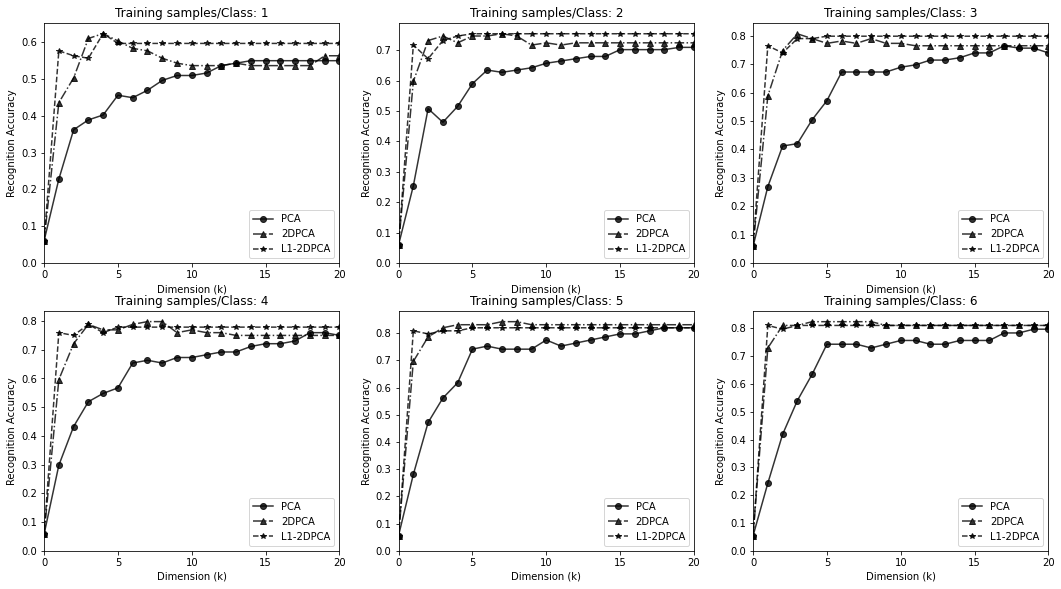

In [155]:
draw_rcgacc_obst2(6)

### 遮挡信息三

In [162]:
from PIL import Image, ImageDraw
import pylab
import random


face_path = './yalefaces/'
X_obst3 = []
random.seed(99)
        
for file in os.listdir(face_path):
    im_fn = os.path.join(face_path, file)
    gif = Image.open(im_fn).resize((w,h), Image.ANTIALIAS)
    
    draw = ImageDraw.Draw(gif) 
    x1 = random.randint(int(w*.2), int(w*.6)); x2 = x1 + random.randint(5, int(w*.8)-x1);
    y1 = random.randint(int(h*.2), int(h*.6)); y2 = y1 + random.randint(5, int(h*.8)-y1);
    draw.rectangle((x1,y1,x2,y2), fill = "#FFFFFF") # (0,0,0))
    
    X_obst3.append(np.asarray(gif))

In [143]:
df_obst3 = pd.DataFrame(zip(X_obst3,y_hum), columns=['img', 'hum']).sort_values('hum')
# acc_res_obst3 = {'PCA':{}, '2DPCA':{}, 'L12D':{}}

In [185]:
def process_obst3(n_keep):
    x_train, y_train, x_test, y_test = split_train_set(df_obst3, n_keep)

    V1 = PCA(x_train)
    V2 = PCA2D(x_train)
    V3 = PCA2D_L1(x_train)

    ######
    i_range = 20

    ######PCA
    acc_res_1 = {}
    for i in range(i_range+1):
        acc = acc_cpt_1d(V1, x_train, x_test, y_train, y_test, i)

        acc_res_1[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    ######2DPCA
    acc_res_2 = {}
    for i in range(i_range+1):
        acc = acc_cpt(V2, x_train, x_test, y_train, y_test, i)

        acc_res_2[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    #######L12DPCA
    acc_res_3 = {}
    for i in range(i_range+1):
        acc = acc_cpt(V3, x_train, x_test, y_train, y_test, i)
        acc_res_3[i] = acc
        if i % 5 == 0:
            print(f"FINISHED n_dim = {i}")

    ####
    acc_res_obst3['PCA'][n_keep] = pd.DataFrame(acc_res_1).mean()
    acc_res_obst3['2DPCA'][n_keep] = pd.DataFrame(acc_res_2).mean()
    acc_res_obst3['L12D'][n_keep] = pd.DataFrame(acc_res_3).mean()
    
def draw_rcgacc_obst3(n_total):
    plt.figure(figsize=(18, 15))

    for n_keep in range(1,n_total+1):
        plt.subplot(3,3,n_keep)            

        plt.plot(acc_res_obst3['PCA'][n_keep], 'ko-', alpha=.8, label="PCA")
        plt.plot(acc_res_obst3['2DPCA'][n_keep], 'k^-.', alpha=.8,  label="2DPCA")
        plt.plot(acc_res_obst3['L12D'][n_keep], 'k*--', alpha=.8, label='L1-2DPCA')

        plt.title("(White Occluder) Training samples/Class: %d" % n_keep)
        plt.xlim(0,i_range)
        plt.xticks(range(0,21,5))
        plt.ylim(0,)
        plt.xlabel("Dimension (k)")
        plt.ylabel("Recognition Accuracy") 
        plt.legend()

    plt.show()

In [145]:
process_obst3(1)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20


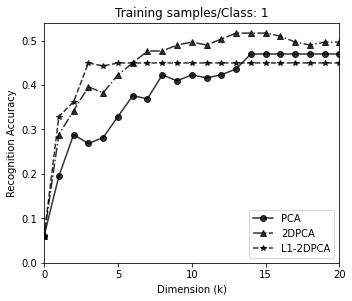

In [147]:
draw_rcgacc_obst3(1)

In [148]:
import time 
for i in range(2,7):
    process_obst3(i)
    time.sleep(30)

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 0
F

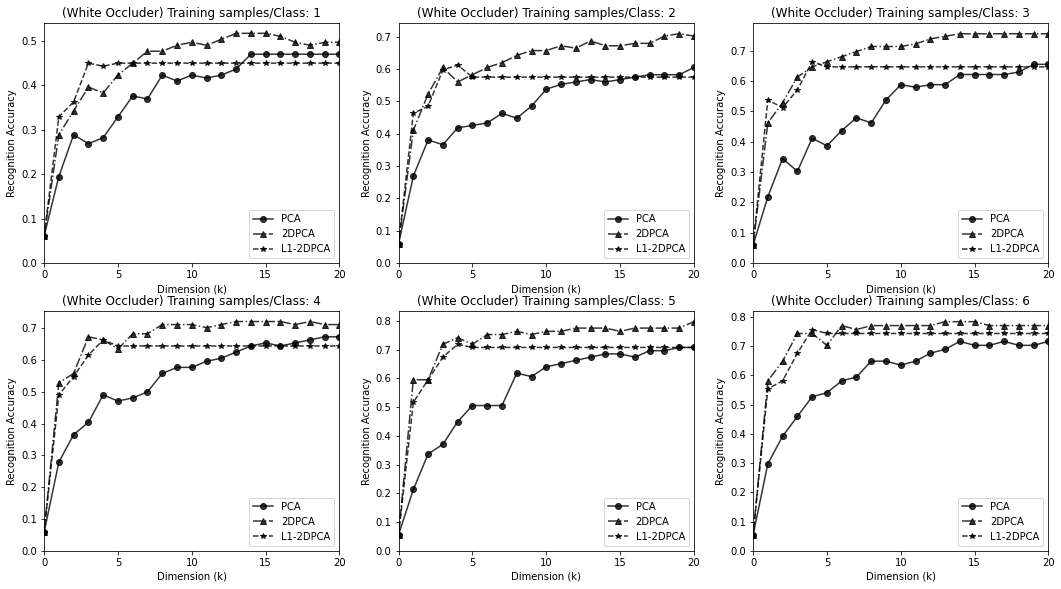

In [186]:
draw_rcgacc_obst3(6)

---
### 不同遮挡矩形的效果对比

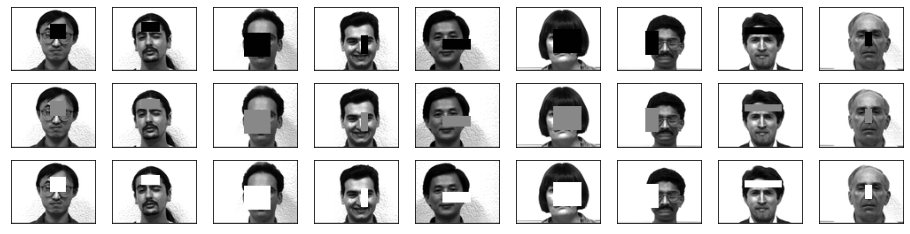

In [172]:
plt.figure(figsize=(16,4))
for i in range(9):
    plt.subplot(3,9,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(X_obst[i], cmap='gray')
for i in range(9):
    plt.subplot(3,9,9+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(X_obst2[i], cmap='gray')
for i in range(9):
    plt.subplot(3,9,18+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(X_obst3[i], cmap='gray')
plt.show()

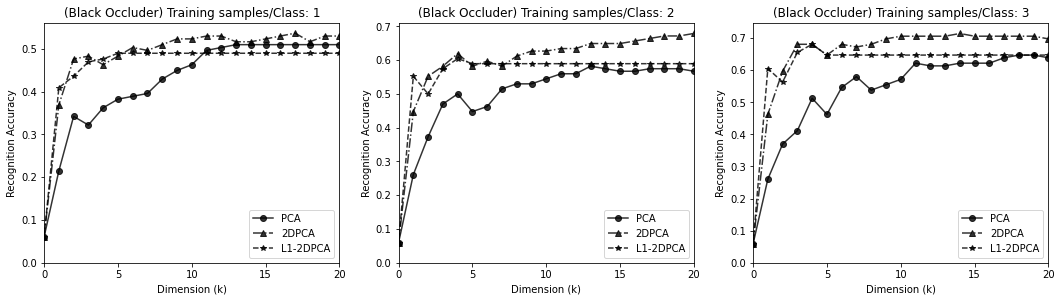

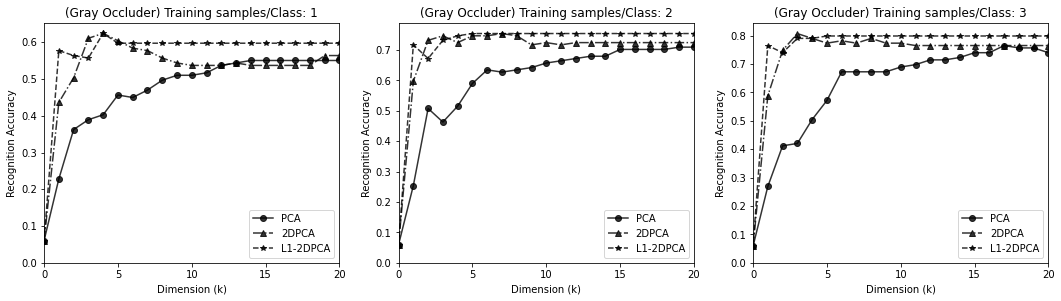

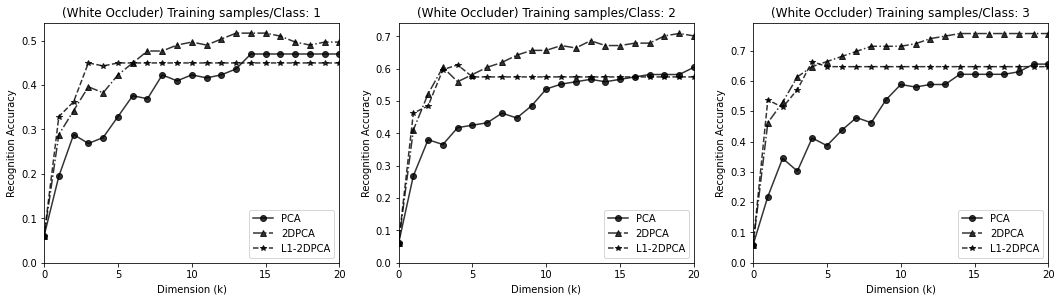

In [187]:
draw_rcgacc_obst(3)
draw_rcgacc_obst2(3)
draw_rcgacc_obst3(3)

In [182]:
print('|sample per class|1|2|3|4|5|6|')
print('|' + '--|' * 7)
df_tmp = pd.DataFrame(acc_res_obst)
print('|*Black Occluder*|||||||')
print('|%s|%s|' % ('PCA', '|'.join(["%.2f (%d)" % (y*100,x) for x, y in zip(df_tmp.PCA.apply(np.argmax), df_tmp.PCA.apply(np.max))])))
print('|%s|%s|' % ('2DPCA', '|'.join(["%.2f (96,%d)" % (y*100,x) for x, y in zip(df_tmp['2DPCA'].apply(np.argmax), df_tmp['2DPCA'].apply(np.max))])))
print('|%s|%s|' % ('L1-2DPCA', '|'.join(["%.2f (96,%d)" % (y*100,x) for x, y in zip(df_tmp['L12D'].apply(np.argmax), df_tmp['L12D'].apply(np.max))])))
df_tmp = pd.DataFrame(acc_res_obst2)
print('|*Gray Occluder*|||||||')
print('|%s|%s|' % ('PCA', '|'.join(["%.2f (%d)" % (y*100,x) for x, y in zip(df_tmp.PCA.apply(np.argmax), df_tmp.PCA.apply(np.max))])))
print('|%s|%s|' % ('2DPCA', '|'.join(["%.2f (96,%d)" % (y*100,x) for x, y in zip(df_tmp['2DPCA'].apply(np.argmax), df_tmp['2DPCA'].apply(np.max))])))
print('|%s|%s|' % ('L1-2DPCA', '|'.join(["%.2f (96,%d)" % (y*100,x) for x, y in zip(df_tmp['L12D'].apply(np.argmax), df_tmp['L12D'].apply(np.max))])))
df_tmp = pd.DataFrame(acc_res_obst3)
print('|*White Occluder*|||||||')
print('|%s|%s|' % ('PCA', '|'.join(["%.2f (%d)" % (y*100,x) for x, y in zip(df_tmp.PCA.apply(np.argmax), df_tmp.PCA.apply(np.max))])))
print('|%s|%s|' % ('2DPCA', '|'.join(["%.2f (96,%d)" % (y*100,x) for x, y in zip(df_tmp['2DPCA'].apply(np.argmax), df_tmp['2DPCA'].apply(np.max))])))
print('|%s|%s|' % ('L1-2DPCA', '|'.join(["%.2f (96,%d)" % (y*100,x) for x, y in zip(df_tmp['L12D'].apply(np.argmax), df_tmp['L12D'].apply(np.max))])))

|sample per class|1|2|3|4|5|6|
|--|--|--|--|--|--|--|
|*Black Occluder*|||||||
|PCA|51.01 (13)|58.21 (13)|64.71 (18)|66.35 (6)|69.66 (13)|68.92 (20)|
|2DPCA|53.69 (96,17)|67.91 (96,20)|71.43 (96,14)|73.08 (96,13)|79.78 (96,13)|78.38 (96,4)|
|L1-2DPCA|48.99 (96,5)|60.45 (96,4)|68.07 (96,4)|72.12 (96,4)|77.53 (96,4)|78.38 (96,4)|
|*Gray Occluder*|||||||
|PCA|55.03 (14)|70.90 (19)|76.47 (17)|75.96 (18)|82.02 (18)|79.73 (19)|
|2DPCA|62.42 (96,4)|75.37 (96,7)|80.67 (96,3)|79.81 (96,7)|84.27 (96,7)|82.43 (96,4)|
|L1-2DPCA|62.42 (96,4)|75.37 (96,5)|79.83 (96,5)|78.85 (96,3)|82.02 (96,5)|81.08 (96,1)|
|*White Occluder*|||||||
|PCA|46.98 (14)|60.45 (20)|65.55 (19)|67.31 (19)|70.79 (19)|71.62 (14)|
|2DPCA|51.68 (96,13)|70.90 (96,19)|75.63 (96,14)|72.12 (96,13)|79.78 (96,20)|78.38 (96,13)|
|L1-2DPCA|44.97 (96,3)|61.19 (96,4)|66.39 (96,4)|66.35 (96,4)|71.91 (96,4)|75.68 (96,4)|


## Time

In [15]:
n_keep = 1
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

In [50]:
%%timeit
V1 = PCA(x_train)

654 ns ± 6.89 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [16]:
%%timeit
V2 = PCA2D(x_train)

9.47 ms ± 286 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit
V3 = PCA2D_L1(x_train)

8.96 ms ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
n_keep = 2
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

In [53]:
%%timeit
V1 = PCA(x_train)

653 ns ± 4.63 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [54]:
%%timeit
V2 = PCA2D(x_train)

11.2 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
%%timeit
V3 = PCA2D_L1(x_train)

17.7 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
n_keep = 3
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

In [57]:
%%timeit
V1 = PCA(x_train)

669 ns ± 3.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [58]:
%%timeit
V2 = PCA2D(x_train)

11.8 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
%%timeit
V3 = PCA2D_L1(x_train)

28.6 ms ± 86.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
n_keep = 4
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

In [61]:
%%timeit
V1 = PCA(x_train)

658 ns ± 3.96 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [62]:
%%timeit
V2 = PCA2D(x_train)

13.6 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
%%timeit
V3 = PCA2D_L1(x_train)

37 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
n_keep = 5
x_train, y_train, x_test, y_test = split_train_set(df, n_keep)

In [66]:
%%timeit
V1 = PCA(x_train)

663 ns ± 9.26 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [67]:
%%timeit
V2 = PCA2D(x_train)

14.1 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
%%timeit
V3 = PCA2D_L1(x_train)

54.1 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


---

（毛思文 2021.04.29）